In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from table_reader import TableReader
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LogisticRegression

Hey folks, I'm just trying out a proof-of-concept jupyter notebook that uses our data retrieval code.

I got sick of working with environment variables so I switched to a new method to store our DB password:
    1. Create a file called config.json in the project root.
    2. Inside, config.json should look like this:
    {
        "database_url":"database_url_goes_here"
    }

TableReader's other vector methods are geodata_vector() and reviews_vector(). Be sure to call close() when you're done so it terminates the connection to the DB.

In [8]:
tr = TableReader()
prop = tr.properties_vector(include_amenitites=True)
geo = tr.geodata_vector()
tr.close()


In [9]:
df = pd.merge(geo,
            prop[['listingID', 'accomodates', 'bathrooms','bedrooms','beds','price','Apartment','Condominium','Elevator','Gym']],
            on='listingID')

In [10]:
df.head()

,listingID,zipcode,latitude,longitude,"Brightwood Park, Crestwood, Petworth","Brookland, Brentwood, Langdon","Capitol Hill, Lincoln Park","Capitol View, Marshall Heights, Benning Heights","Cathedral Heights, McLean Gardens, Glover Park","Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace",...,"Woodridge, Fort Lincoln, Gateway",accomodates,bathrooms,bedrooms,beds,price,Apartment,Condominium,Elevator,Gym
0,124030,20001.0,38.91409,-77.02484,0,0,0,0,0,0,...,0,4,2.0,2.0,1.0,150,0,1,0,0
1,3344,20005.0,38.90126,-77.02857,0,0,0,0,0,0,...,0,1,1.0,1.0,1.0,48,0,1,1,1
2,3662,20020.0,38.86193,-76.98963,0,0,0,0,0,0,...,0,1,1.0,1.0,1.0,65,0,0,0,0
3,3686,20020.0,38.86314,-76.98836,0,0,0,0,0,0,...,0,1,1.0,1.0,1.0,55,0,0,0,0
4,3771,20009.0,38.92760,-77.03926,0,0,0,0,0,0,...,0,2,1.0,1.0,1.0,88,0,0,0,0


In [11]:
features = df[df.columns.drop(['price', 'listingID'])]
label = df['price']

In [12]:
model = ElasticNet()
esfm = SelectFromModel(model)
esfm.fit(features, label)
print(list(features.iloc[:, esfm.get_support(indices=True)]))

['Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'accomodates', 'bathrooms', 'bedrooms', 'Elevator', 'Gym']


In [13]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['zipcode', 'Capitol Hill, Lincoln Park', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Shaw, Logan Circle', 'accomodates', 'bathrooms', 'bedrooms', 'beds', 'Apartment', 'Elevator', 'Gym']


In [14]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['latitude', 'longitude', 'Capitol Hill, Lincoln Park', 'Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Georgetown, Burleith/Hillandale', 'Howard University, Le Droit Park, Cardozo/Shaw', 'Kalorama Heights, Adams Morgan, Lanier Heights', 'Near Southeast, Navy Yard', 'Shaw, Logan Circle', 'Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point', 'Union Station, Stanton Park, Kingman Park', 'West End, Foggy Bottom, GWU']


In [15]:
elastic_data = df[list(features.iloc[:, esfm.get_support(indices=True)])]

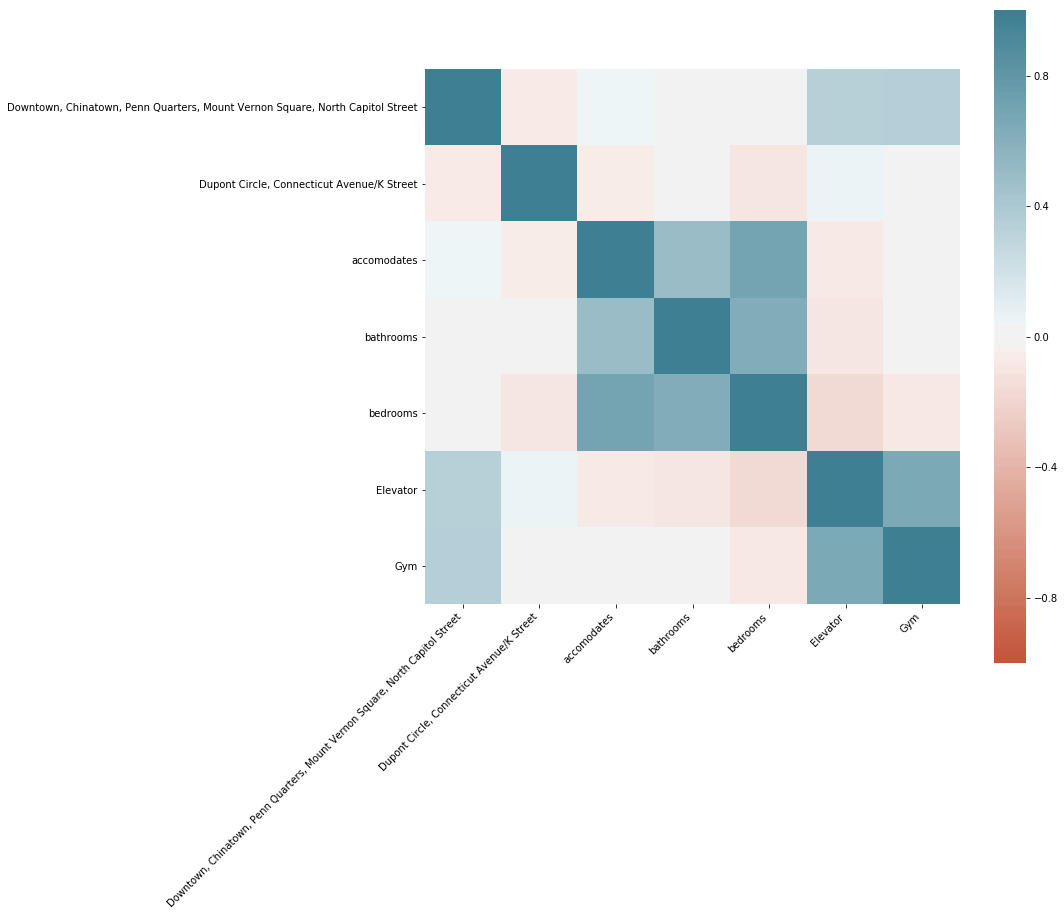

In [16]:
corr = elastic_data.corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = tts(features, label, test_size=0.2)


In [29]:
regr = LinearRegression()
regr.fit(X_train,y_train)
print(mean_squared_error(y_test, regr.predict(X_test)))
print(regr.score(X_test,y_test))

3397.472294026809
0.4333741739526389


In [31]:
import numpy as np

# try 200 different alphas between -10 and -2
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

model_ridge = RidgeCV(alphas=alphas)
model_ridge.fit(X_train, y_train)

#which alpha did it pick?
print(model_ridge.alpha_)


0.01


In [32]:
ridge = Ridge(alpha=0.01)
model_ridge.fit(X_train, y_train)
print(mean_squared_error(y_test, model_ridge.predict(X_test)))
print(model_ridge.score(X_test, y_test))

3397.273887333839
0.43340726395207607


In [33]:
lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train)
print(mean_squared_error(y_test, lasso.predict(X_test)))
lasso.score(X_test, y_test)

3597.4019341761677


0.40003017944820907

In [ ]:
model = LogisticRegression().fit(X_train, y_train)
get_internal_params(model)

print(mean_squared_error(y_test, clf.predict(X_test)))
clf.score(X_test, y_test)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
